In [1]:
import torch
import argparse
import numpy as np
import scanpy as sc
import copy
from torch.utils.data import DataLoader

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, adjusted_rand_score,
                             calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)

In [2]:
'''
mean是正态分布的mean，scale是sigma
'''
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Encoder, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.GELU()
             
        )
        self.mean = torch.nn.Linear(hidden_dim, output_dim)
        self.scale = torch.nn.Sequential(torch.nn.Linear(hidden_dim, output_dim), torch.nn.Softplus())
        
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                    torch.nn.init.kaiming_uniform_(m.weight)
                    
    def forward(self, x):
        q = self.net(x)
        return self.mean(q), self.scale(q)
    
class Decoder(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Decoder, self).__init__()
        self.lam = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.GELU(),
            torch.nn.Linear(hidden_dim, output_dim),
            torch.nn.Softplus()
        )
        
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                    torch.nn.init.kaiming_uniform_(m.weight)

    def forward(self, x):
        return self.lam(x) + 1e-15

In [3]:
def kl_term(mean, scale):
    """
    KL divergence between N(mean, scale) and N(0, 1)
    mean.shape(cells,hidden_dim)
    scale.shape(cells.hidden_dim)
    在隐空间上计算KL
    """
    return .5 * (1 - 2 * torch.log(scale) + (mean * mean + scale * scale))

def pois_llik(x, mean):
    """Return the log likelihood of x distributed as Poisson"""
    return x * torch.log(mean) - mean - torch.lgamma(x + 1)

def nb_llik(x, mean, inv_disp):
    """
    Return the log likelihood of x distributed as NB
    See Hilbe 2012, eq. 8.10
    mean - mean (> 0)
    inv_disp - inverse dispersion (> 0)
    """
    return (x * torch.log(mean / inv_disp) -
            x * torch.log(1 + mean / inv_disp) -
            inv_disp * torch.log(1 + mean / inv_disp) +
            torch.lgamma(x + inv_disp) -
            torch.lgamma(inv_disp) -
            torch.lgamma(x + 1))

def zinb_llik(x, mean, inv_disp, logodds):
    """Return the log likelihood of x distributed as ZINB
    See Hilbe 2012, eq. 11.12, 11.13
    mean - mean (> 0)
    inv_disp - inverse dispersion (> 0)
    logodds - logit point mass weight
    """
    # Important identities:
    # log(x + y) = log(x) + softplus(log(y) - log(x))
    # log(sigmoid(x)) = -softplus(-x)
    softplus = torch.nn.functional.softplus
    case_zero = -softplus(-logodds) + softplus(nb_llik(x, mean, inv_disp) - logodds)
    case_non_zero = -softplus(logodds) + nb_llik(x, mean, inv_disp)
    return torch.where(torch.lt(x, 1), case_zero, case_non_zero)

In [4]:
class PVAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(PVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def loss(self, x):
        mean, scale = self.encoder.forward(x)
        kl = torch.sum(kl_term(mean, scale), dim=1)#return(1,cells)每一个样本的embedding对应的kl, 
        qz = torch.distributions.Normal(mean, scale).rsample()#可以添加n_samples进行多次采样，qz.shape (cells, latent_dim)
        lam = self.decoder.forward(qz)#返回的是(cells,genes)
        error = torch.sum(pois_llik(x, lam), dim=1)
        loss = -torch.mean(error - kl)
        return loss
    
    def fit(self, max_epoch, patience, verbose=False):
        self.to(device)

        optimizer = torch.optim.Adam(self.parameters(), lr=3e-5)
        
        bad_count = 0
        best_test_loss = 10000
        best_model = None
        
        for epoch in range(max_epoch):
            self.train()
            for x in dataloader:
                #x = x.float().to(device)
                
                optimizer.zero_grad()
                loss = self.loss(x)
                loss.backward()
                optimizer.step()
            
            self.eval()
            test_loss = self.loss(adata_test)
            
            if test_loss.item() < best_test_loss:
                best_test_loss = test_loss.item()
                bad_count = 0 
                best_model = copy.deepcopy(self)
            
            else:
                bad_count += 1
                
            if bad_count >= patience:
                break    
                    
            if verbose:
                print(f'[epoch {epoch}] test_elbo = {test_loss}')
        
        self = copy.deepcopy(best_model)
    
        return self
            
    @torch.no_grad()
    def predict(self, x):
        x = x.float().to(device)
        mean, scale = self.encoder.forward(x)
        mu = self.decoder.forward(mean)
        return mu, mean

    @torch.no_grad()
    def denoise(self, x):
        return self.predict(x)
    
class NBVAE(PVAE):
    def __init__(self, input_dim, latent_dim, disp_by_gene=True):
        """Initialize the VAE parameters
        disp_by_gene - if True, model one dispersion parameter per gene
        """
        # Important: only μ is a neural network output, so we can actually reuse
        # the entire PVAE.
        super().__init__(input_dim, latent_dim)
        if disp_by_gene:
            # Important: shape needs to be correct to broadcast
            self.log_inv_disp = torch.nn.Parameter(torch.zeros([1, input_dim]))
        else:
            self.log_inv_disp = torch.nn.Parameter(torch.zeros([1]))
    
    def loss(self, x):
        mean, scale = self.encoder.forward(x)
        kl = torch.sum(kl_term(mean, scale), dim=1)#return(1,cells)每一个样本的embedding对应的kl
        qz = torch.distributions.Normal(mean, scale).rsample()#qz.shape (cells, latent_dim)
        mu = self.decoder.forward(qz)
        error = torch.sum(nb_llik(x, mu, torch.exp(self.log_inv_disp)), dim=1)
        loss = -torch.mean(error - kl)
        return loss

    @torch.no_grad()
    def denoise(self, x):
        x = x.float().to(device)
        mu, embedding = self.predict(x)
        # E[lam | g] = E_z[E[lam | z, g]]
        lam = (x + torch.exp(self.log_inv_disp)) / (torch.exp(self.log_inv_disp) / mu + 1)
        lam = lam.cpu()
        return lam.numpy(), embedding
    
class ZINBVAE(NBVAE):
    def __init__(self, input_dim, latent_dim, disp_by_gene=True, logodds_by_gene=True):
        # Important: only μ is a neural network output, and we still need
        # log_inv_disp, so we can actually reuse the entire NBVAE.
        super().__init__(input_dim, latent_dim, disp_by_gene=disp_by_gene)
        if logodds_by_gene:
            self.logodds = torch.nn.Parameter(torch.zeros([1, input_dim]))
        else:
            self.logodds = torch.nn.Parameter(torch.zeros([1]))
            
    def loss(self, x):
        mean, scale = self.encoder.forward(x)
        kl = torch.sum(kl_term(mean, scale), dim=1)#return(1,cells)每一个样本的embedding对应的kl
        qz = torch.distributions.Normal(mean, scale).rsample()#可以添加n_samples进行多次采样，qz.shape (cells, latent_dim)
        mu = self.decoder.forward(qz)
        error = torch.sum(zinb_llik(x, mu, torch.exp(self.log_inv_disp), self.logodds), dim=1)
        loss = -torch.mean(error - kl)
        
        return loss
    
    @torch.no_grad()
    def denoise(self, x):
        x = x.float().to(device)
        mu, embedding = self.predict(x)
        # E[lam | g] = E_z[E[lam | z, g]]
        lam = torch.sigmoid(-self.logodds) * (x + torch.exp(self.log_inv_disp)) / (torch.exp(self.log_inv_disp) / mu + 1)
        lam = lam.cpu()
        return lam.numpy(), embedding

In [5]:
dataset = [
    '../../data/Young.h5ad',
    '../../data/mouse_ES_cell.h5ad',
    '../../data/mouse_bladder.h5ad',
    '../../data/worm_neuron.h5ad',
    '../../data/QS_Trachea.h5ad',
    '../../data/10X_PBMC.h5ad',
    '../../data/Romanov.h5ad',
    '../../data/QS_Diaphragm.h5ad',
    '../../data/QS_Limb_Muscle.h5ad',
    '../../data/QS_Lung.h5ad'
    ]

In [6]:
dataset = [
    '../../data/Young.h5ad',
    ]

In [9]:
result = []
device = torch.device('cuda:1')
for i in dataset:
    adata = sc.read_h5ad(i)
    sc.pp.filter_cells(adata, min_genes=1)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.filter_cells(adata, min_counts=1)
    adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000, subset=True)
    
    true_label = np.array(adata.obs.cell_label)
    nclusters = (np.unique(true_label).max() - np.unique(true_label).min() + 1).astype(int)
    print('Successfully preprocessed {} cells and {} genes in {} clusters.'.format(adata.n_obs, adata.n_vars, nclusters))

    ari_klist = []
    for j in range(1):
            
        adata_train, adata_test = train_test_split(adata.X, test_size=0.05, shuffle=True, random_state=0)#选择训练和测试的时候shuffle
        adata_train = torch.tensor(adata_train).to(device)
        adata_test = torch.tensor(adata_test).to(device)
        dataloader = DataLoader(adata_train, batch_size=256, shuffle=True)#选择minibatch shuffle
        kmeans = KMeans(n_clusters=nclusters, init="k-means++",random_state=21)
    
        model = ZINBVAE(input_dim=adata.X.shape[1], latent_dim=64).fit(max_epoch=3000, patience=15, verbose=False)
        mu, embedding = model.denoise(torch.tensor(adata.X))
        kmeans_pred = kmeans.fit_predict(embedding.cpu())
        ari_k = round(adjusted_rand_score(true_label, kmeans_pred), 4)
        ari_klist.append(ari_k)
        print(ari_k)
        
    ari = sum(ari_klist)/len(ari_klist)
    result.append(ari)
    print(result)
    
    print('------------{} is Done'.format(i))

Successfully preprocessed 5685 cells and 3000 genes in 11 clusters.
0.6758
[0.6758]
------------../../data/Young.h5ad is Done


In [40]:
result

[0.6868, 0.8177, 0.4364, 0.5002, 0.414, 0.7711, 0.691, 0.8754, 0.6006, 0.5229]

In [41]:
sum(result)/len(result)

0.63161

In [12]:
import matplotlib.pyplot as plt
def draw_fig(list1, list2, epoch):
    x1 = range(1, epoch+1)
    y1 = list1
    y2 = list2
    plt.cla()
    plt.title('loss vs. epoch', fontsize=20)
    plt.plot(x1, y1)
    plt.plot(x1, y2)
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.grid()
    plt.show()

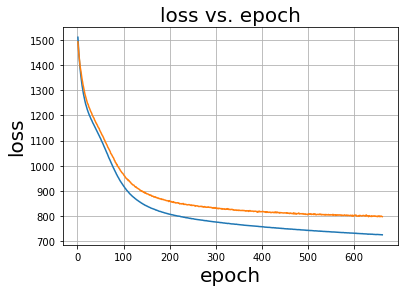

In [13]:
draw_fig(train, test, len(train))